# PolygonRNN++ Demo
This demo will illustrates step by step how to run PolygonRNN++ on a sample image crop.

In [3]:
#imports
import tensorflow as tf
import numpy as np
from PolygonModel import PolygonModel
from EvalNet import EvalNet
from GGNNPolyModel import GGNNPolygonModel
import utils
from poly_utils import vis_polys
import skimage.io as io

In [4]:
#External PATHS
PolyRNN_metagraph='../models/poly/polygonplusplus.ckpt.meta'
PolyRNN_checkpoint='../models/poly/polygonplusplus.ckpt'
EvalNet_checkpoint='../models/evalnet/evalnet.ckpt'
GGNN_metagraph='../models/ggnn/ggnn.ckpt.meta'
GGNN_checkpoint='../models/ggnn/ggnn.ckpt'

#Const
_BATCH_SIZE=1
_FIRST_TOP_K = 6

In [6]:
# Creating the graphs
evalGraph = tf.Graph()
polyGraph = tf.Graph()
ggnnGraph = tf.Graph()

In [7]:
#Initializing and restoring the evaluator net.
with evalGraph.as_default():
    with tf.variable_scope("discriminator_network"):
        evaluator = EvalNet(_BATCH_SIZE)
        evaluator.build_graph()
    saver = tf.train.Saver()

    # Start session
    evalSess = tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True
    ), graph=evalGraph)
    saver.restore(evalSess, EvalNet_checkpoint)

INFO:tensorflow:Restoring parameters from ../models/evalnet/evalnet.ckpt


In [9]:
#Initializing and restoring PolyRNN++
model = PolygonModel(PolyRNN_metagraph, polyGraph)
model.register_eval_fn(lambda input_: evaluator.do_test(evalSess, input_))
polySess = tf.Session(config=tf.ConfigProto(
    allow_soft_placement=True
), graph=polyGraph)
model.saver.restore(polySess, PolyRNN_checkpoint)

INFO:tensorflow:Restoring parameters from ../models/poly/polygonplusplus.ckpt


In [10]:
#Initializing and restoring GGNN
ggnnGraph = tf.Graph()
ggnnModel = GGNNPolygonModel(GGNN_metagraph, ggnnGraph)
ggnnSess = tf.Session(config=tf.ConfigProto(
    allow_soft_placement=True
), graph=ggnnGraph)

ggnnModel.saver.restore(ggnnSess,GGNN_checkpoint)

INFO:tensorflow:Restoring parameters from ../models/ggnn/ggnn.ckpt


In [11]:
#INPUT IMG CROP (224x224x3) -> object should be centered
crop_path='../imgs/frankfurt_000000_000294_42.png'

In [12]:
#Testing
image_np = io.imread(crop_path)
image_np = np.expand_dims(image_np, axis=0)
preds = [model.do_test(polySess, image_np, top_k) for top_k in range(_FIRST_TOP_K)]

# sort predictions based on the eval score to pick the best.
preds = sorted(preds, key=lambda x: x['scores'][0], reverse=True)

[None, None, None, None, None, None]

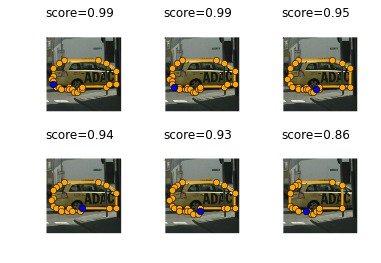

In [13]:
#Visualizing TOP_K and scores
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,3)
axes=np.array(axes).flatten()
[vis_polys(axes[i], image_np[0], np.array(pred['polys'][0]), title='score=%.2f' % pred['scores'][0]) for i,pred in enumerate(preds)]

In [14]:
#Let's run GGNN now on the bestPoly
bestPoly = preds[0]['polys'][0]
feature_indexs, poly, mask = utils.preprocess_ggnn_input(bestPoly)
preds_gnn = ggnnModel.do_test(ggnnSess, image_np, feature_indexs, poly, mask)
refinedPoly=preds_gnn['polys_ggnn']

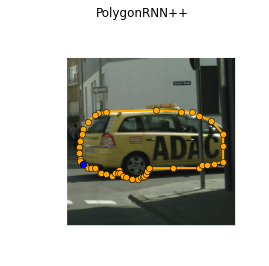

In [15]:
#Visualize the final prediction
fig, ax = plt.subplots(1,1)
vis_polys(ax,image_np[0],refinedPoly[0], title='PolygonRNN++')